#For colab

In [7]:
import numpy as np
import pandas as pd
import collections
import json
from google.colab import drive
from matplotlib import pyplot as plt

drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
#No biased에 대한 결과가 요정도..
def draw_pnl(input_pnl, index_list) :
    draw_data = pd.Series(input_pnl)
    draw_data.index = index_list
    plt.figure(figsize=(10,5))
    plt.plot(draw_data)
    plt.grid(b = True)
    return draw_data



In [0]:
"""
with open('..//data//daily_price_small.json') as json_file:
    json_data = json.load(json_file)
price_s = pd.read_json(json_data)

"""


#import price data
with open('/gdrive/My Drive/대학원 2학기/딥러닝/Deeplearning_pj/DL_final_proj/data/daily_price_small.json') as f:
    price_json = json.load(f)
price_s = pd.read_json(price_json)
"""

with open('/gdrive/My Drive/대학원 2학기/딥러닝/Deeplearning_pj/DL_final_proj/data/daily_price.json') as f:
    price_json = json.load(f)
price_s = pd.read_json(price_json)
"""

#import cluster data; industry code
with open('/gdrive/My Drive/대학원 2학기/딥러닝/Deeplearning_pj/DL_final_proj/data/industry_code.json') as f:
    industry_json = json.load(f)
industry_s = pd.read_json(industry_json)

#Del off-days 

#idx of double 
double_idx = np.full(len(price_s.index), False, dtype = bool)

for i in range(len(price_s.index)) :
    oneday_arr = price_s.values[i]
  
    if i ==0 :
        pre_arr = oneday_arr
        continue ;
    #get non np array for calc norm distance btw pre & curr day return 
    nz_idx = np.isnan(oneday_arr)

    if np.linalg.norm(oneday_arr[~nz_idx]  - pre_arr[~nz_idx]) < 0.001 :
        double_idx[i] = True
        

    pre_arr = oneday_arr

# Extract only working days
price_s = price_s.loc[price_s.index[~double_idx],:]
industry_s = industry_s.loc[industry_s.index[~double_idx],:]


2009-01-01       737.16
2009-01-02      1908.65
2009-01-05      2119.86
2009-01-06      3137.73
2009-01-07      4357.12
                ...    
2019-11-08    101541.35
2019-11-11    101513.74
2019-11-12    101665.39
2019-11-13    101453.86
2019-11-14    101506.20
Length: 2689, dtype: float64

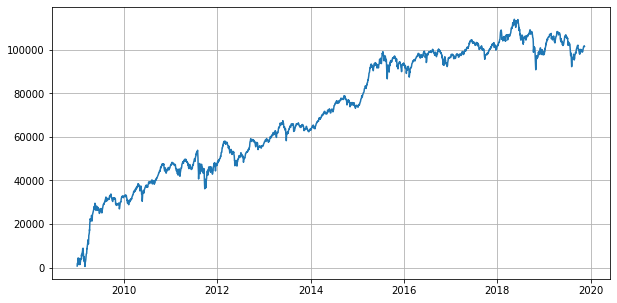

In [21]:
#Survival biased에 대한 결과가 요정도..
daily_mean = np.cumsum (np.nansum(price_s.values, 1))
draw_pnl(daily_mean, price_s.index)

2009-01-01        0.000
2009-01-02        0.000
2009-01-05        0.000
2009-01-06        0.000
2009-01-07      871.424
                ...    
2019-11-08    99272.148
2019-11-11    99465.370
2019-11-12    99633.076
2019-11-13    99696.208
2019-11-14    99745.900
Length: 2689, dtype: float64

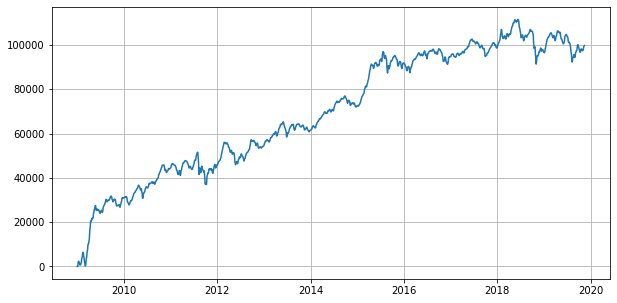

In [22]:
daily_rolling_mean = np.cumsum (np.nansum(price_s.rolling(5).mean().values, 1))
draw_pnl(daily_rolling_mean, price_s.index)

In [0]:
#re-sizeing industry_s
dump_df = price_s.copy()
for col in price_s.columns :
    dump_df[col] = industry_s[col]
industry_s = dump_df

In [0]:
# there are some anormaly data with float and int
for column in industry_s.columns:
    industry_s[column] = industry_s[column].apply(lambda x : np.nan if type(x) == int or type(x) == float else x )


#Calc industry loading matrix



In [0]:
# get_industry_list 

df = pd.read_excel("/gdrive/My Drive/대학원 2학기/딥러닝/Deeplearning_pj/DL_final_proj/raw_data/Industry_code.xlsx")
df.columns = df.iloc[7]
df = df[13:]
df = df.set_index('Symbol')

for i in df.columns :
    if i == df.columns[0]:
        c = collections.Counter(df[i])
    c += collections.Counter(df[i])

industry_list = [*c.keys()]
#industry_list
ndustry_list.remove(np.nan)



In [0]:
#get loading dic 
# 
industry_dic = {}
for industry in industry_list :
    #industry_dic.update({ industry :np.where(industry_s.values == industry, True, False)})
    industry_dic.update({ industry :np.where(industry_s.values == industry, 1, 0)})

#np.matrix(industry_dic[industry_list[0]]).shape
loading_m= industry_dic[industry_list[0]]

cluster meanreversion 

In [97]:
#5 Day Mean reversion  
pr_rolling = price_s.rolling(5, min_periods=1).mean()
pr_rolling_ar = pr_rolling.values


input_data = pr_rolling
total_ammount = 1

portfolio = np.zeros(input_data.shape)
nn_price_s = np.where(np.isnan(input_data), 0, input_data)

for industry in industry_list :
    loading_m = industry_dic[industry]
    loading_return = np.multiply(loading_m , nn_price_s)
    for i in range(len(price_s.index)) :
        loading_return[i]  -= np.mean(loading_return[i])

    loading_return = np.where(np.isnan(price_s.values[i]), 0, loading_return)
    portfolio += loading_return
portfolio = np.where(np.isnan(price_s.values),0 , portfolio)
portfolio = np.where(portfolio > 0 , -1, 1)

abs_sum = np.sum(np.abs(portfolio), 1)
weight = total_ammount/abs_sum 
weight[total_ammount/abs_sum == np.inf] = 0
d = np.diag(weight)
portfolio_w = np.matmul(d, portfolio )


#make portfolio df with init zero
portfolio_df = price_s.copy()
for col in portfolio_df.columns:
    portfolio_df[col].values[:] = 0

portfolio_df.loc[:,:] = portfolio_w
portfolio_df = portfolio_df.shift(1)
portfolio_df.head(4)


,A005930,A000660,A035420,A005380,A207940,A068270,A012330,A051910,A055550,A051900,A028260,A017670,A005490,A034730,A105560,A000270,A015760,A006400,A018260,A096770,A032830,A033780,A035720,A003550,A036570,A090430,A010950,A066570,A000810,A086790,A316140,A009150,A009540,A010130,A011170,A251270,A002790,A030200,A024110,A035250,...,A032710,A037620,A038400,A042100,A045710,A045820,A051310,A053000,A060000,A063350,A063510,A064420,A067250,A068870,A069470,A076170,A079660,A101990,A103150,A103160,A104110,A104120,A108070,A110570,A114410,A117930,A121910,A122290,A122750,A192520,A192530,A272210,A308170,A317400,A322000,A900030,A900050,A950010,A950070,A950100
2009-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-02,0.000867,-0.000867,-0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,-0.000867,0.000867,0.000867,-0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,-0.000867,0.000867,0.000867,-0.000867,-0.000867,-0.000867,-0.000867,0.000867,0.000867,-0.000867,-0.000867,0.000867,0.000867,-0.000867,-0.000867,-0.000867,0.000867,-0.000867,0.000867,0.000867,-0.000867,...,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867
2009-01-05,-0.000867,-0.000867,0.000867,-0.000867,0.000867,0.000867,-0.000867,-0.000867,0.000867,0.000867,0.000867,0.000867,-0.000867,0.000867,0.000867,-0.000867,0.000867,-0.000867,0.000867,-0.000867,0.000867,0.000867,0.000867,-0.000867,-0.000867,0.000867,0.000867,-0.000867,-0.000867,0.000867,0.000867,0.000867,-0.000867,-0.000867,-0.000867,0.000867,0.000867,-0.000867,0.000867,0.000867,...,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867
2009-01-06,-0.000867,-0.000867,0.000867,-0.000867,0.000867,0.000867,-0.000867,-0.000867,-0.000867,0.000867,0.000867,0.000867,-0.000867,0.000867,-0.000867,-0.000867,-0.000867,-0.000867,0.000867,-0.000867,0.000867,0.000867,0.000867,-0.000867,-0.000867,0.000867,0.000867,-0.000867,0.000867,-0.000867,0.000867,0.000867,-0.000867,-0.000867,-0.000867,0.000867,0.000867,-0.000867,-0.000867,0.000867,...,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867,0.000867


In [0]:
industry_s.tail(300)

2009-01-01     0.000000
2009-01-02     0.278674
2009-01-05     0.169584
2009-01-06    -0.016664
2009-01-07    -0.500243
                ...    
2018-09-03    43.272782
2018-09-04    43.273180
2018-09-05    43.296768
2018-09-06    43.222218
2018-09-07    43.143510
Length: 2400, dtype: float64

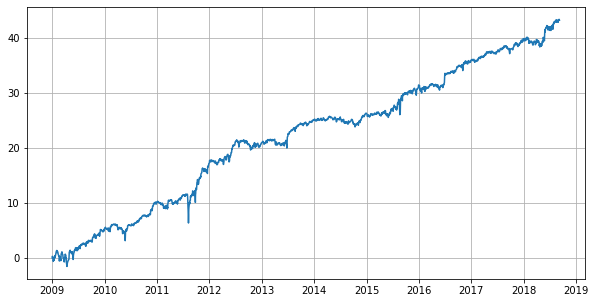

In [108]:
daily_pnl = np.nansum(np.multiply( portfolio_df.values, price_s.values),1)
draw_pnl(np.cumsum(daily_pnl[:2400]), price_s.index[:2400])

In [162]:
"""
이거 계산 빠르게 만들어야 함..
numpy matrix 연산으로 바꿔서 계산..
각 클러스터 마다 demean 된 수익률 메트릭스 가지고 매트릭스를 더하면 그게 포트폴리오
거기에 abs로 나누면되겠네.

"""


#make portfolio df with init zero
portfolio_df = price_s.copy()
for col in portfolio_df.columns:
    portfolio_df[col].values[:] = 0


#get portfolio matrix
day_list = price_s.index

for day_idx, day in enumerate(day_list) :
    if day_idx == len(day_list) -1:
        break ;

    for cluster in industry_list :
        daily_return_arr = price_s.values[day_idx]
        k_loading_arr = industry_dic[cluster][day_idx]
        nz_idx = np.isnan(daily_return_arr)
        k_mean_re = np.nanmean(daily_return_arr[k_loading_arr])

        #calc alpha 
        portfolio_df.loc[day_list[day_idx+1], k_loading_arr] = -1 * (daily_return_arr[k_loading_arr]- k_mean_re)
        portfolio_df.loc[day_list[day_idx+1], nz_idx] = 0



"""
i = 12
day = portfolio_df.index[0]
daily_return_arr = price_s.values[i]
k_loading_arr = industry_dic['I.005'][i]
nz_idx = np.isnan(daily_return_arr)

k_mean_re = np.nanmean(daily_return_arr[k_loading_arr])

#portfolio_df.loc[day, k_loading_arr] = -1 * (np.where(np.isnan(daily_return_arr[k_loading_arr]), 0, daily_return_arr[k_loading_arr]) - k_mean_re)
portfolio_df.loc[day, k_loading_arr] = -1 * (daily_return_arr[k_loading_arr]- k_mean_re)
portfolio_df.loc[day, nz_idx] = 0

"""


"""
checking portfolio weight
#np.nansum(portfolio_df.loc[day, k_loading_arr].values)
sum(portfolio_df.loc[day, k_loading_arr].values)

"""
#k_mean_re = (np.dot(daily_return_arr[~nz_idx],k_loading_arr[~nz_idx]))/np.nansum(k_loading_arr)
 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice


'\nchecking portfolio weight\n#np.nansum(portfolio_df.loc[day, k_loading_arr].values)\nsum(portfolio_df.loc[day, k_loading_arr].values)\n\n'

In [0]:
portfolio_df_2 = portfolio_df.copy()


#short_term reversion 

price data랑 industry 데이터 종목 검토 필요
예상 시나리오 : price_s 가  필터링 된 종목일 것.
그러면 일단 price_small에 맞춰서  industry_loading matrix 재조정 필요.


In [45]:

#5 Day Mean reversion  
pr_rolling = price_s.rolling(5, min_periods=1).mean()
#pr_rolling_ar = pr_rolling.values


#input_data = pr_rolling
input_data = pr_rolling
total_ammount = 1

#make portfolio df with init zero
portfolio_df = price_s.copy()
for col in portfolio_df.columns:
    portfolio_df[col].values[:] = 0


#Calc  alpha
for i,index in enumerate(input_data.index) :
    
    if i == len(input_data.index)-1 :
        break ;
    day_pr_arr = input_data.values[i]

    alpha =  (day_pr_arr - np.nanmean(day_pr_arr))
    alpha[~np.isnan(day_pr_arr)] = np.where( alpha[~np.isnan(day_pr_arr)] > 0, -1, 1)
    alpha -= np.nanmean(alpha)
    #alpha = -1 * (day_pr_arr -pr_rolling_ar[i] )
    weight_value = total_ammount/ np.sum(np.abs(day_pr_arr[~np.isnan(day_pr_arr)]))   

    alpha[~np.isnan(day_pr_arr)] = weight_value * alpha[~np.isnan(day_pr_arr)]
    
    portfolio_df.loc[input_data.index[i+1], :] = alpha


#check overall dollor neutral 
sum (np.nansum(portfolio_df.values, 1) < 10^-3)

0

2009-01-01    0.000000e+00
2009-01-02    2.483744e+05
2009-01-05    1.253670e+05
2009-01-06    4.724583e+04
2009-01-07   -5.860431e+04
                  ...     
2019-11-08    8.835062e+06
2019-11-11    8.701153e+06
2019-11-12    8.740237e+06
2019-11-13    8.854160e+06
2019-11-14    8.977978e+06
Length: 2689, dtype: float64

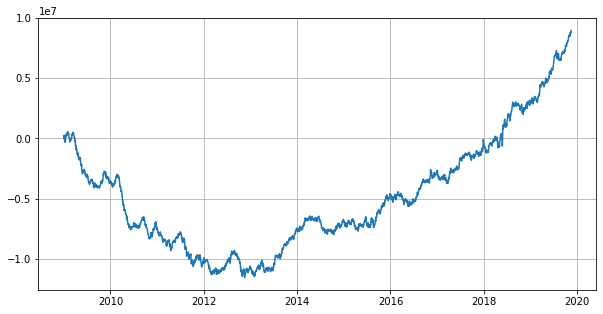

In [41]:
#1-day mean rv
daily_pnl = np.nansum(np.multiply( portfolio_df.values, price_s.values),1)
draw_pnl(np.cumsum(daily_pnl), price_s.index)

2009-01-01     0.000000
2009-01-02     0.248374
2009-01-05     0.178763
2009-01-06     0.114273
2009-01-07    -0.317261
                ...    
2019-11-08    96.048276
2019-11-11    96.162881
2019-11-12    96.346607
2019-11-13    96.203950
2019-11-14    96.872599
Length: 2689, dtype: float64

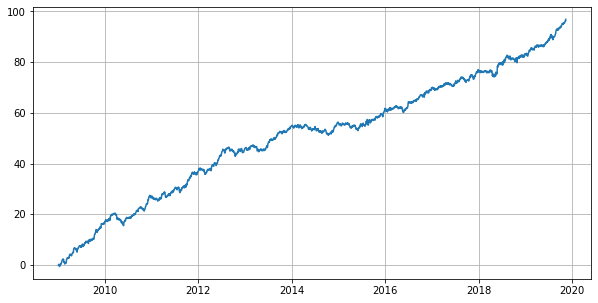

In [46]:
#5-day mean rv
daily_pnl = np.nansum(np.multiply( portfolio_df.values, price_s.values),1)
draw_pnl(np.cumsum(daily_pnl), price_s.index)

2009-01-01    0.000000e+00
2009-01-02    2.483744e+05
2009-01-05    1.787631e+05
2009-01-06    1.142729e+05
2009-01-07   -3.172607e+05
                  ...     
2019-11-08    7.477651e+07
2019-11-11    7.462077e+07
2019-11-12    7.477290e+07
2019-11-13    7.464355e+07
2019-11-14    7.516743e+07
Length: 2689, dtype: float64

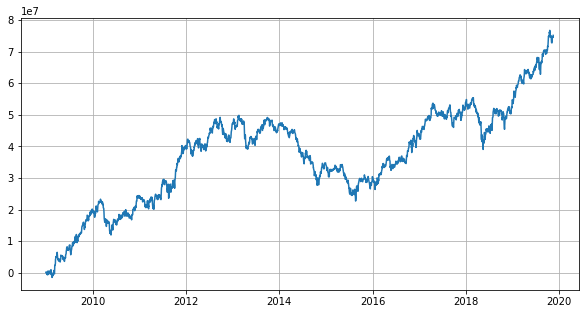

In [43]:
#21-day mean rv
daily_pnl = np.nansum(np.multiply( portfolio_df.values, price_s.values),1)
draw_pnl(np.cumsum(daily_pnl), price_s.index)

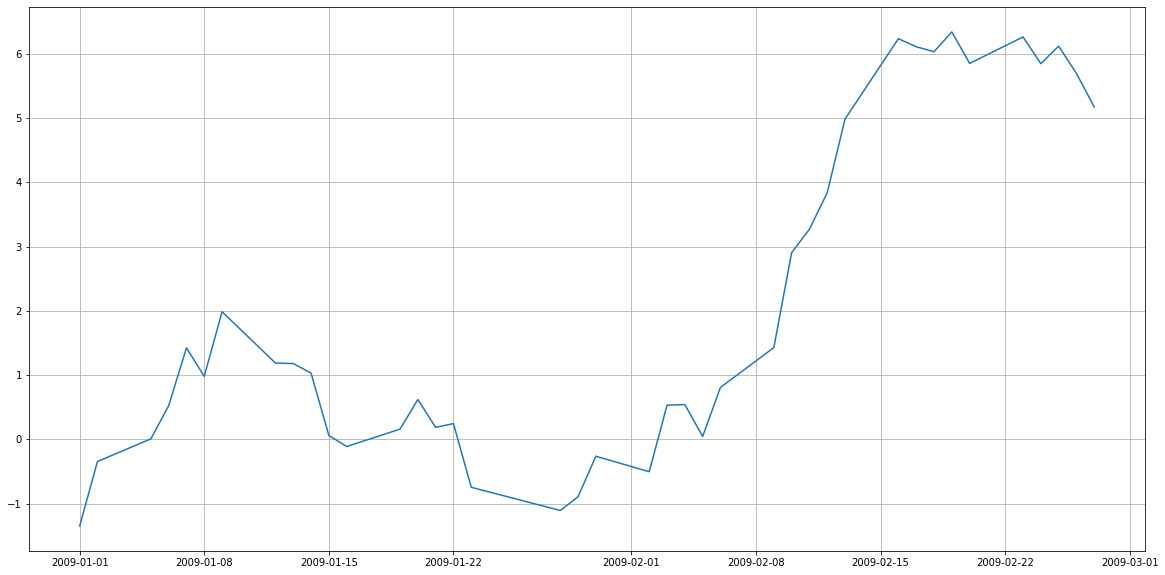

In [281]:
#back-testing by portfolio
price_arr = price_s.values
port_arr = portfolio_df.values
pf_p_l = np.zeros(len(port_arr))

for i in range(len(port_arr)) :
    a_2 = port_arr[i]
    a_1 = price_arr[i]
    pf_p_l[i] = np.inner(a_1[~np.isnan(a_1)], a_2[~np.isnan(a_1)])

p_and_l = np.cumsum(pf_p_l[1:])/total_ammount


pnl_s = pd.Series(p_and_l)
pnl_s.index = price_s.index[:-1]

from matplotlib import pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(pnl_s)
plt.grid(b = True)

In [282]:
pnl_s

2009-01-01   -1.351158
2009-01-02   -0.346009
2009-01-05    0.006410
2009-01-06    0.522566
2009-01-07    1.422885
                ...   
2019-11-07         NaN
2019-11-08         NaN
2019-11-11         NaN
2019-11-12         NaN
2019-11-13         NaN
Length: 2688, dtype: float64

In [0]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(pnl_s)
plt.grid(b = True)

pf_p_l_s = pd.Series(pf_p_l)
pf_p_l_s.index = price_s.index
plt.figure(figsize=(20,10))
plt.plot(pf_p_l_s)
plt.grid(b = True)
#pf_p_l_s


#Del off days


In [0]:

#idx of double 
double_idx = np.full(len(w=1price_s.index), False, dtype = bool)

for i in range(len(price_s.index)) :
    oneday_arr = price_s.values[i]
  
    if i ==0 :
        pre_arr = oneday_arr
        continue ;
    #get non np array for calc norm distance btw pre & curr day return 
    nz_idx = np.isnan(oneday_arr)

    if np.linalg.norm(oneday_arr[~nz_idx]  - pre_arr[~nz_idx]) < 0.001 :
        double_idx[i] = True
        

    pre_arr = oneday_arr

# Extract only working days
real_price = price_s.loc[price_s.index[~double_idx],:]


#miscellaneous


In [0]:
price_s.values[0] - np.nanmean(price_s.values[0])
np.nan(np.nanprice_s.values[0])
np.isnan(price_s.values[0] )
day_pr_arr = price_s.values[0]
day_pr_arr_demean = day_pr_arr - np.nanmean(day_pr_arr)
total_ammount = 1000000
weight_value = total_ammount/ np.sum(np.abs(day_pr_arr[~np.isnan(day_pr_arr)]))
alpha = day_pr_arr_demean
alpha[~np.isnan(day_pr_arr)] = weight_value * alpha[~np.isnan(day_pr_arr)]
portfolio_df = price_s.copy()
for col in portfolio_df.columns:
    portfolio_df[col].values[:] = 0
portfolio_df.loc[price_s.index[1], :] = alpha